In [54]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as tf
import torchvision.datasets as tfds
import torchvision
from torchvision.transforms import ToPILImage

In [27]:
imgfolder = ImageFolder('./COVID-19_Radiography_Database/images/',
                       transform=tf.Compose([tf.Resize(1024,1024),tf.ToTensor(),
                                            ]))

In [28]:
dataset_loader = torch.utils.data.DataLoader(imgfolder,
                                             batch_size=2, shuffle=True)

In [5]:
f = next(iter(dataset_loader))[0][0]

In [8]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

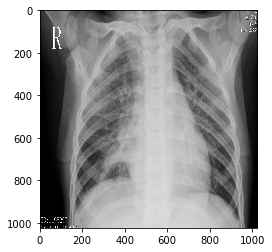

In [11]:
show(f)

In [12]:
f.shape

torch.Size([3, 1024, 1024])

In [49]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 6, 3, stride=2) #512
        self.conv2 = nn.Conv2d(6, 16, 3, stride=2) #256
        self.conv3 = nn.Conv2d(16, 24, 3, stride=2) #128
        self.conv4 = nn.Conv2d(24, 32, 3, stride=2) #64
        self.flatten = nn.Flatten()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(288, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = F.max_pool2d(F.relu(self.conv4(x)), 2)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



net = Net()

In [50]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataset_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')